In [2]:
import os
from typing import *
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import xml.etree.ElementTree as ET

In [81]:
class CustomOxFordPet(Dataset):
    def __init__(self, root:str = None, split = 'trainval', transform = None, sematic_transform = None):
        self.root = root if root else "/media/mountHDD2/oxfordpet"
        self._split = split

        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose(
                [
                    transforms.Resize((256, 256)),
                    transforms.ToTensor()
                ]
            )

        if sematic_transform:
            self.sematic_transform = sematic_transform
        else:
            self.sematic_transform = transforms.Compose(
                [
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(), 
                    self.process_mask
                ]
            )

        self._images_folder = self.root + "/images"
        self._anns_folder = self.root + "/annotations"
        self._segs_folder = self._anns_folder + "/trimaps"
        self._bbox_folder = self._anns_folder + "/xmls"

        image_ids = []
        self._labels = []
        with open(self._anns_folder + f"/{self._split}.txt") as file:
            for line in file:
                image_id, label, *_ = line.strip().split()
                image_ids.append(image_id)
                self._labels.append(int(label) - 1)

        self.classes = [
            " ".join(part.title() for part in raw_cls.split("_"))
            for raw_cls, _ in sorted(
                {(image_id.rsplit("_", 1)[0], label) for image_id, label in zip(image_ids, self._labels)},
                key=lambda image_id_and_label: image_id_and_label[1],
            )
        ]
        self.class_to_idx = dict(zip(self.classes, range(len(self.classes))))

        self._images = [self._images_folder + f"/{image_id}.jpg" for image_id in image_ids]
        self._segs = [self._segs_folder + f"/{image_id}.png" for image_id in image_ids]
        self._xmls = [self._bbox_folder + f"/{image_id}.xml" for image_id in image_ids]

        self.simple_cls = {
            "dog" : 0,
            "cat" : 1
        }

    @staticmethod
    def process_mask(x):
        uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        x = x.to(dtype=torch.long)
        print(x.shape)
        onehot = F.one_hot(x.squeeze(1), 3).permute(0, 3, 1, 2)[0].float()
        return onehot[:-1]

    @staticmethod
    def process_bbox(_xml, ori_img_size: tuple):
        oriheight = ori_img_size[0]
        oriwidth = ori_img_size[1]
        
        xmin = int(_xml[5][4][0].text)
        ymin = int(_xml[5][4][1].text)
        xmax = int(_xml[5][4][2].text)
        ymax = int(_xml[5][4][3].text)

        target_size = 256
        x_scale = target_size / oriwidth
        y_scale = target_size / oriheight

        xmin = int(np.round(xmin * x_scale))
        ymin = int(np.round(ymin * y_scale))
        xmax = int(np.round(xmax * x_scale))
        ymax = int(np.round(ymax * y_scale))

        return torch.from_numpy(np.array([xmin, ymin, xmax, ymax])) / 256.0

    def __len__(self):
        return len(self._images)

    def __getitem__(self, idx):
        image = Image.open(self._images[idx]).convert("RGB")
        mask = Image.open(self._segs[idx])

        width, height = image.size

        _xml = ET.parse(self._xmls[idx]).getroot()

        simple_category = self.simple_cls[_xml[5][0].text]

        img = self.transform(image)

        target = {
            "semantic" : self.sematic_transform(mask),
            "category" : self._labels[idx],
            "simple_category" : simple_category, 
            "poly" : self.process_bbox(_xml, (height, width))
        }

        return img, target

In [82]:
trainval_ds = CustomOxFordPet(split = 'trainval')
test_ds = CustomOxFordPet(split = 'test')

print(len(trainval_ds))
print(len(test_ds))

3680
3669


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([2, 256, 256])/torch.float32
category: 0
simple_category: 1
poly Shape/Dtype: torch.Size([4])/torch.float32
[98, 36, 218, 137]
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([2, 256, 256])/torch.float32
category: 0
simple_category: 1
poly Shape/Dtype: torch.Size([4])/torch.float32
[31, 29, 181, 192]
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([2, 256, 256])/torch.float32
category: 0
simple_category: 1
poly Shape/Dtype: torch.Size([4])/torch.float32
[12, 15, 166, 176]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([2, 256, 256])/torch.float32
category: 0
simple_category: 1
poly Shape/Dtype: torch.Size([4])/torch.float32
[123, 50, 185, 143]


FileNotFoundError: [Errno 2] No such file or directory: '/media/mountHDD2/oxfordpet/annotations/xmls/Abyssinian_104.xml'

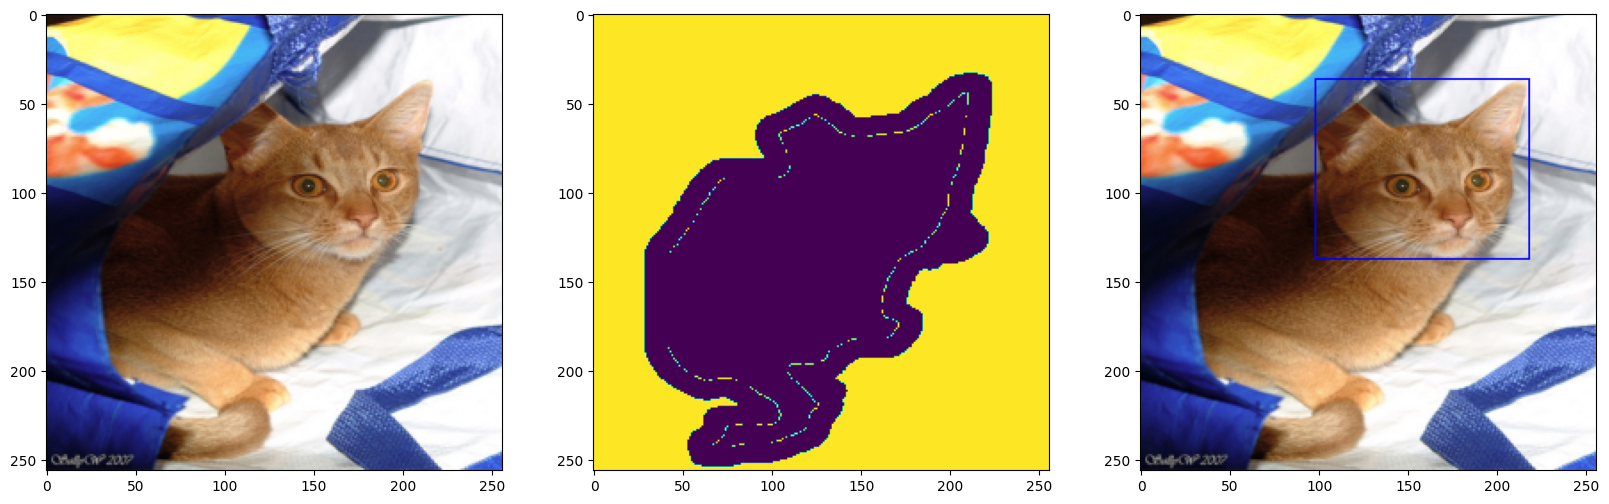

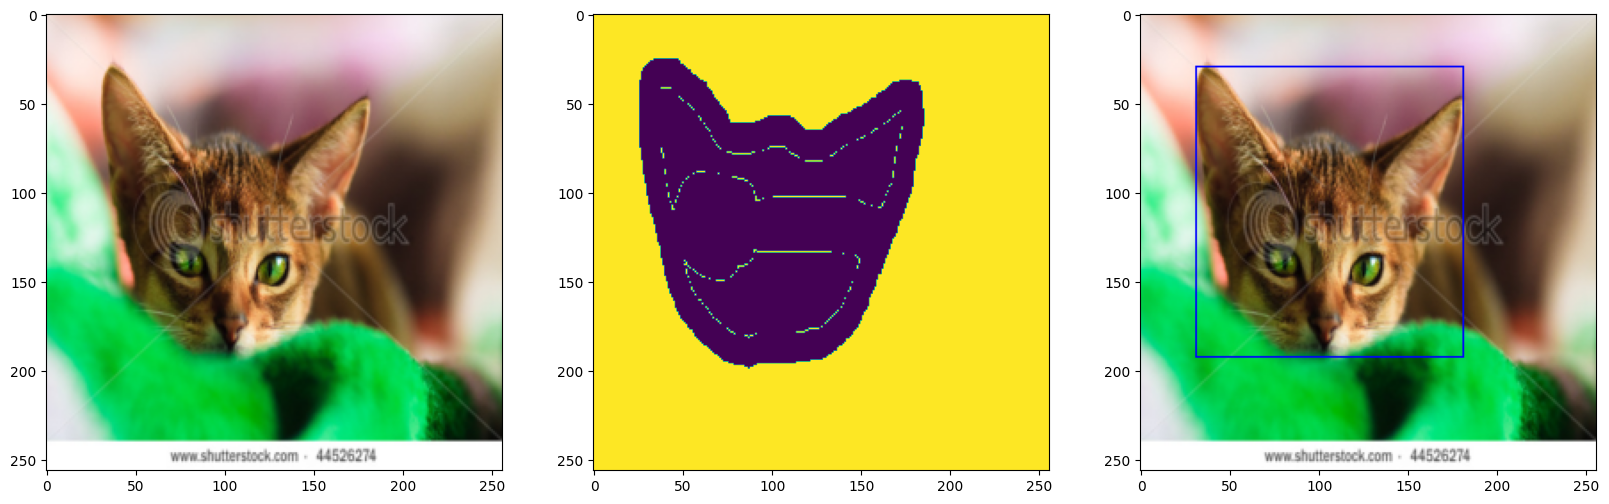

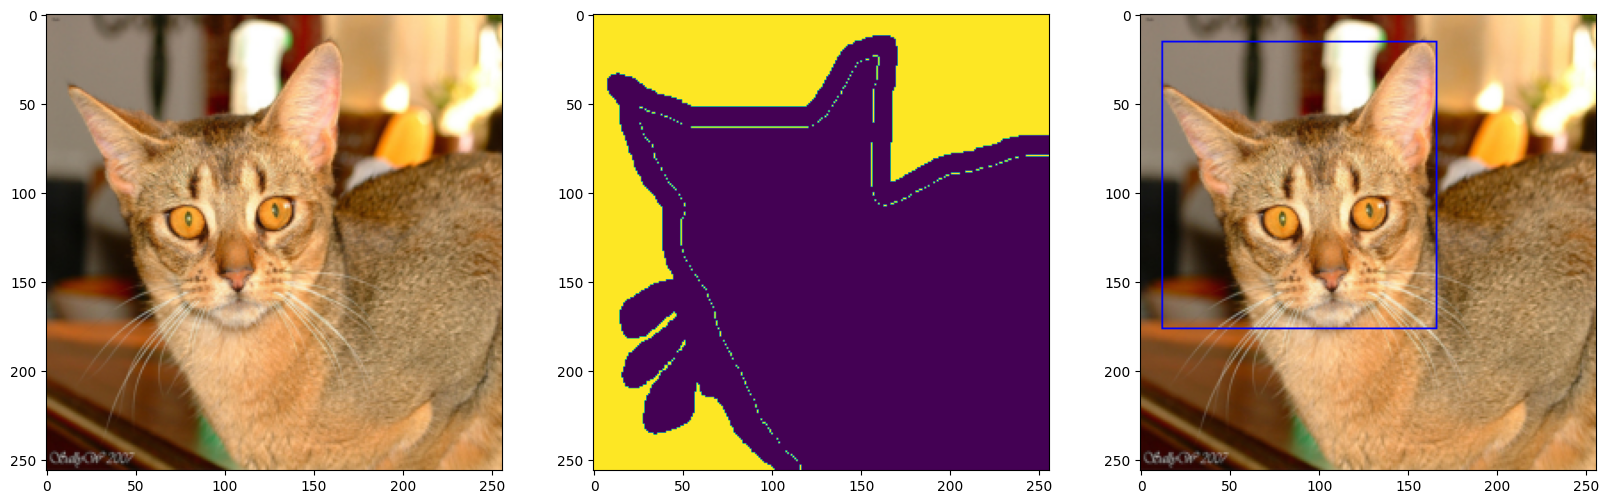

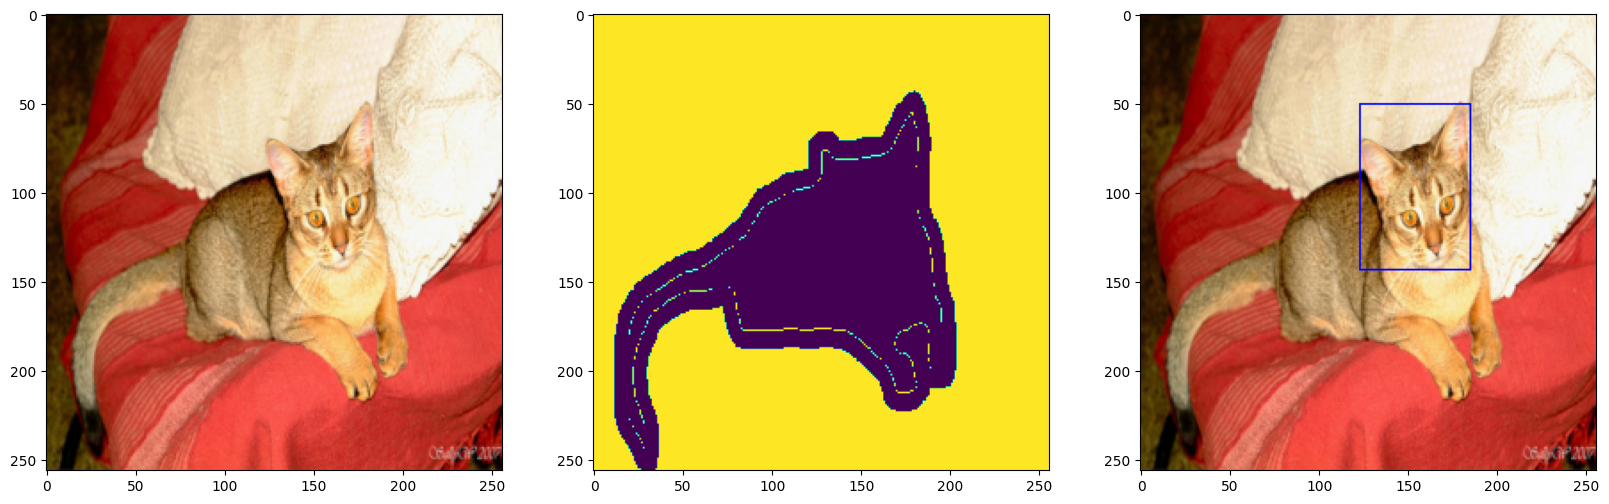

In [103]:
for idx in range(5):
    img, target = trainval_ds[idx]

    print(f"Image Shape/Dtype: {img.shape}/{img.dtype}")
    for key in target:
        if isinstance(target[key], int):
            print(f"{key}: {target[key]}")
        else:
            print(f"{key} Shape/Dtype: {target[key].shape}/{target[key].dtype}")

    img_np = img.permute(1, -1, 0).numpy()

    f, axarr = plt.subplots(1, 3, figsize=(20, 15))
    axarr[0].imshow(img_np)
    axarr[1].imshow(torch.argmax(target['semantic'], dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

    unnormalized_bbox = (target['poly']*256).numpy().tolist()
    xmin = int(unnormalized_bbox[0])
    ymin = int(unnormalized_bbox[1])
    xmax = int(unnormalized_bbox[2])
    ymax = int(unnormalized_bbox[3])

    print([xmin, ymin, xmax, ymax])

    img_np = np.array(img_np)

    map_img_np = np.zeros(shape = (256, 256, 3), dtype=np.float32)
    map_img_np += img_np

    draw_img_np = cv2.rectangle(map_img_np, (xmin, ymin), (xmax, ymax), (0, 0, 120), 1) 
    
    axarr[2].imshow(draw_img_np)